In [1]:
# Script for multiple runs of wanderlust 
%load_ext autoreload
%autoreload 2

import warnings

# data processing
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    import scanpy.api as sc
import numpy as np
import scanpy.api as sc
import pandas as pd
import os
import scipy.sparse as sp

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# change logging settings for scanpy
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.settings.n_jobs = 30
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0+unknown on 2018-04-10 20:24.
Dependencies: anndata==0.5.8 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


### FULL DATASET

In [2]:
all_data = sc.read_h5ad('../../data/tasks/sampling/ica_bone_marrow.h5ad')

### initial 10K cells

In [3]:
adata=sc.read_h5ad('./write/sdata_clustered.h5ad') 

### Function for DCSS 

In [4]:
# imported from https://github.com/srmcc/dcss_single_cell
from scipy.sparse.linalg import svds

def det_leverage(V, k, epsilon):
    """
    for the data matrix A=U \Sigma V^T
    A.shape =(n=number of samples, d=number of features)
    V.shape=(d, n)
    k is the rank of the PCA leverage score
    epsilon is the error parameter.
    the function returns
    theta: the number of kept columns
    index_keep: the index of the selected columns
    tau_sorted:  the sorted leverage scores of all the columns
    index_drop:  the index of the dropped columns
    """
    V = pd.DataFrame(V)
    Vk= V.iloc[:, 0:k]
    print(Vk.shape)
    tau= np.sum(Vk**2, axis=1)
    tau_sorted= tau.sort_values(ascending=False, inplace=False)
    lev_sum=0
    for i in range(V.shape[0]):
        lev_sum =lev_sum+ tau_sorted.iloc[i]
        if lev_sum > k - epsilon:
            theta=i+1
            if theta >= k:
                break
    index_keep= tau_sorted.index[0:theta]
    index_keep = index_keep.values
    index_drop = tau_sorted.index[theta:]
    index_drop= index_drop.values
    return(theta, index_keep, tau_sorted, index_drop)

In [5]:
#calculate singular vectors (svd)
u,s,vt=svds(adata.raw.X,k=50)

In [6]:
# running column subset selection
(theta, index_keep, tau_sorted, index_drop)=det_leverage(vt.T,5,0.5)

(33694, 5)


In [7]:
# index of genes to keep
index_keep

array([32490,  3977, 31453, 10736, 21035, 23865, 24694, 11106,  1933,
       25308, 15211, 31763,  1899, 14381,  5262,   895, 17058, 33654,
       24383,  1897, 23126, 23858, 33655, 31866, 26699,  9818, 13864,
       23862, 33658,   484, 15890,  8374, 20799, 11469,  3957, 14102,
       28116,  7966, 33653,  5538, 22065, 23773, 28395, 17874, 25617,
       33659,  8234,  4204, 30532, 17183, 20289, 30228, 33661, 16671,
       32527,  3692, 11907, 17185, 31726,  5088, 30263, 32919, 21030,
       27344, 22226,  9146, 30227, 19471, 30420, 15117, 19594, 27152,
       27034,  7149, 22102, 30226, 16980, 17381, 10589, 10433,  7711,
       30905, 32042,  5611,  7710, 29888, 27725,  9992, 10704, 18295,
       32570,  1906, 32858, 27520, 16698,  1090, 10619, 31365, 18012])

In [8]:
# removing ribosomal and mitochondrial from selected genes
genes=[i for i in adata.raw.var_names[index_keep] if not (i.startswith('RP') or i.startswith('MT'))]
len(genes)

48

In [9]:
# keeping first 36 genes
genes=genes[:36]

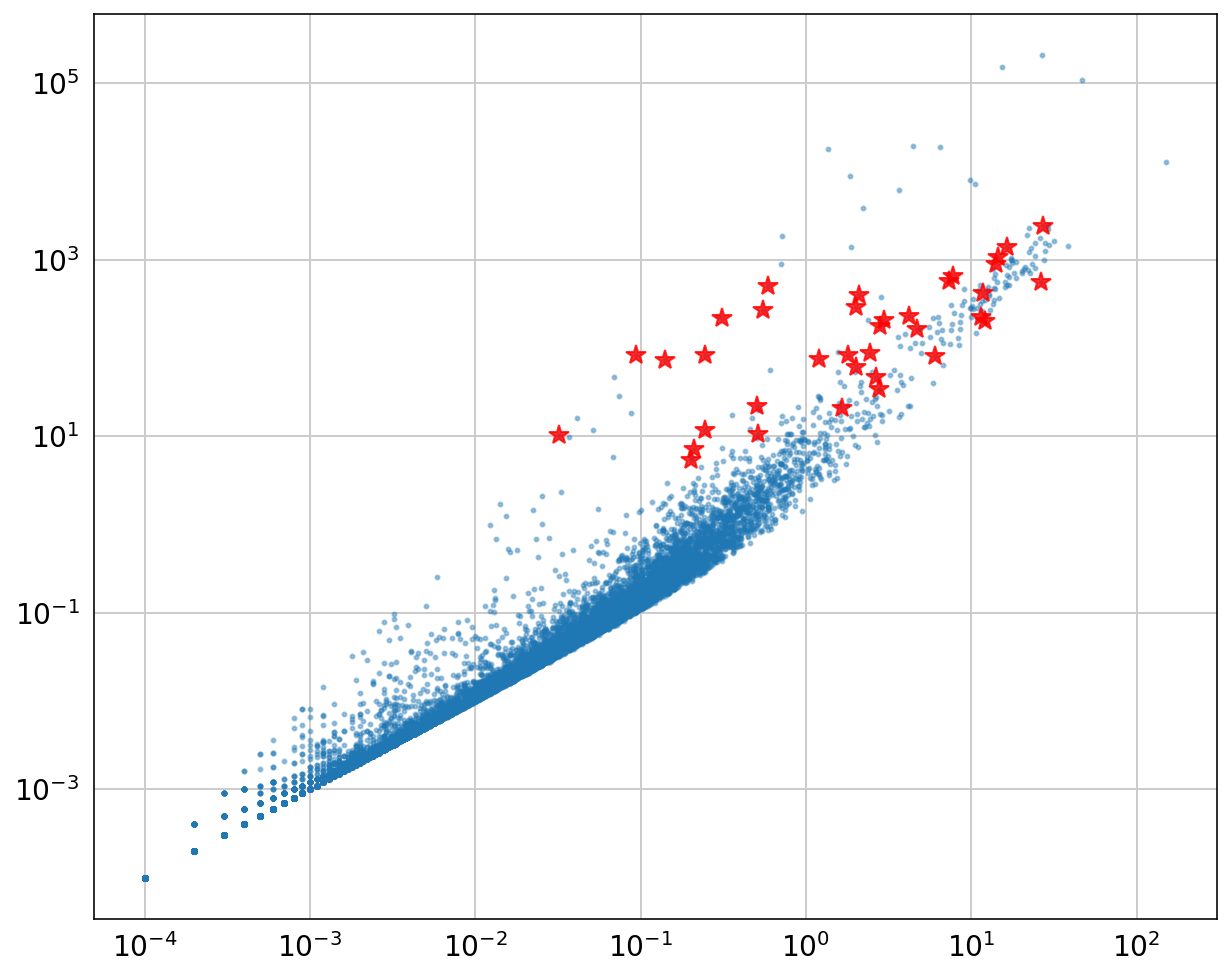

In [10]:
# plotting mean - variance scatter plot with annotation of selected genes
plt.figure(figsize=(10,8))
mean=adata.raw.X.mean(axis=0)
var=np.var(adata.raw.X.todense(),axis=0)
mean=np.array(mean)[0]
var=np.array(var)[0]

mean2=adata.raw[:,genes].X.mean(axis=0)
var2=np.var(adata.raw[:,genes].X.todense(),axis=0)
mean2=np.array(mean2)[0]
var2=np.array(var2)[0]

plt.loglog(mean,var,'.',alpha=0.4,markersize=4)
plt.loglog(mean2,var2,'*',alpha=0.8,color='r',markersize=10)

## FACS

In [11]:
# splitting selected genes into 6 experiments
Fgenes=np.array([genes[6*i:6*(i+1)] for i in range(6)])

In [12]:
Fgenes

array([['IGLV1-47', 'GNLY', 'IGHGP', 'EEF1A1', 'CA1', 'S100A8'],
       ['PTMA', 'B2M', 'S100A9', 'IGHA2', 'NKG7', 'IGHG4'],
       ['HMGB2', 'TUBA1B', 'TMSB10', 'MPO', 'HSP90AA1', 'H3F3B'],
       ['FTH1', 'HBD', 'GAPDH', 'ELANE', 'IGLV2-18', 'ACTB'],
       ['HBG2', 'FTL', 'TPT1', 'PRTN3', 'SRGN', 'UBB'],
       ['HMGB1', 'AZU1', 'TUBB4B', 'TUBB', 'HIST1H4C', 'PPBP']],
      dtype='<U8')

In [15]:
import scipy.stats as st

# get gaussian kernel
def get_kernel(data, bw_method):
    '''data: numpy array cells x dimensions'''
    kernel = st.gaussian_kde(data.T, bw_method=bw_method)
    
    return kernel

# sampling function
def sample(kernel, n, x_sample,lambda1):

    def g(x, lamb): 
        return 1 - np.exp(-lamb*x)

    sampled_points=[]
    for i,x in enumerate(x_sample):
        s=np.random.rand(1) < g(1 / (1e-20+kernel(x)), lambda1)
        if s[0]:
            sampled_points+=[i] 
        if len(sampled_points) >= n:
            break
    
    return sampled_points

In [16]:
def get_data(idx,anndata):
    
    retdata=sc.AnnData(anndata.X[idx,:])
    retdata.var_names=anndata.var_names
    retdata.obs_names = anndata.obs_names[idx]
    
    return retdata

In [38]:
%%time
idx=[]

cells_per_machine=1000

# sample cells

for i in range(6):

    A_train=np.array(adata.raw[:,list(Fgenes[i])].X.todense())
    
    kern=get_kernel(A_train,'scott')
    lambd=np.percentile(kern(A_train.T),20)    
    Q=np.array(all_data[:,list(Fgenes[i])].X.todense())
    
    perm=np.random.permutation(Q.shape[0])
    Q=Q[perm,:]
    
    idx+=[perm[sample(kern,cells_per_machine,Q,lambd)]]

CPU times: user 52.3 s, sys: 4 ms, total: 52.3 s
Wall time: 52.3 s


In [39]:
# flatten list of cells
idx_all = np.array(idx).ravel()

In [40]:
len(idx_all)

6000

In [41]:
idx_=np.unique(idx_all)

In [42]:
# prepare results for evaluation
sampled_cell_names=all_data.obs_names[idx_]
original_cell_names = adata.obs_names
select=np.unique(list(sampled_cell_names)+list(original_cell_names))
len(select)

15797

In [43]:
tmp_Set_select=set(select)
mask=np.array([True if (i in tmp_Set_select) else False for i in all_data.obs_names ])

In [44]:
samp_data=sc.AnnData(all_data.X[np.where(mask==1)[0],:])
samp_data.var_names=all_data.var_names
samp_data.obs_names = all_data.obs_names[np.where(mask==1)[0]]

In [45]:
labels=['original'  if i in original_cell_names else 'sampled' for i in samp_data.obs_names]
samp_data.obs['sampled'] = labels

In [46]:
samp_data

AnnData object with n_obs × n_vars = 15797 × 33694 
    obs: 'sampled'

In [47]:
samp_data.write('./write/samp_data_v1_000000.h5ad')